## Description

In the Histopathologic Cancer Detection competition, we must create an model that can accurately identify metastatic cancer in small image patches taken from larger digital pathology scans. Accurate detection is crucial for early diagnosis and treatment planning in cancer patients.
https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

## Data Characteristics
A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.<br>
**Image Size:** 96x96px<br>
**Color Channels:** 3 (RGB)<br>
**Format:** .tif files<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Paths to the data directories
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Load the labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [3]:
import pathlib

train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

print(len(train_imgs))
print(len(test_imgs))

220025
57458


In [4]:
import os
# Get training and testing files
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif', '5a32933e093185f5fc91d30fc83ad571c6818d25.tif', '42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif', '27bb898f54a0b9345f6c4a9083299e4465860861.tif', '89cd55e4300440612347c38f306da688a166fd40.tif', 'cd600f77aa2af7c93dc6cd836e44edada3d8c403.tif']
Testing image files: 
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif', 'd23c66547f4a00555a174d2fcb860ae399b66edc.tif', 'fabf2fca23f71655974767e29eda86a9b2c97a72.tif', '9730b15862516b8641b9f0ff48db660d95031c32.tif', 'ee85348c0950c2e639776fb555e3452c1f8437c0.tif', 'ef12a0813c504d2d1b2ba485e78d380ad64a0622

## Data Preview

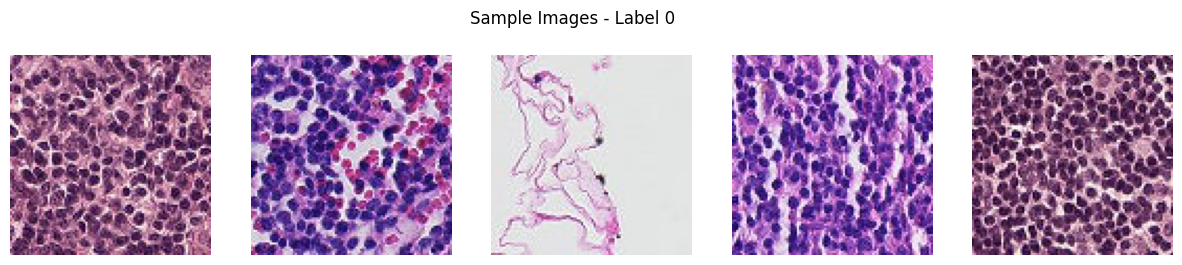

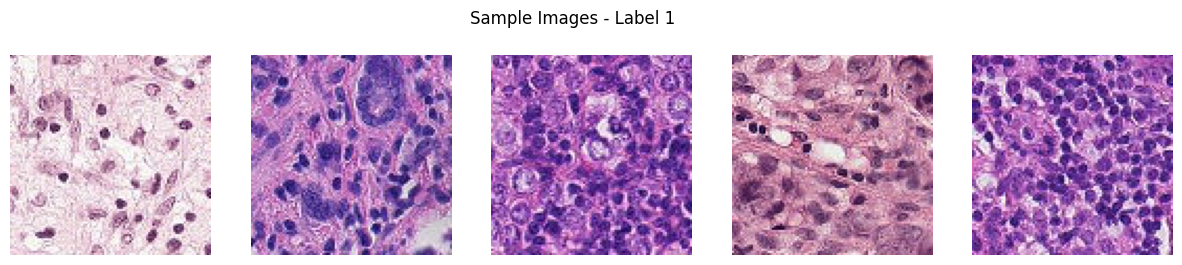

In [5]:
def show_samples(label, num_samples=5):
    samples = labels[labels['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

show_samples(label=0)
show_samples(label=1)

In [6]:
# Missing values
labels.isnull().sum()

id       0
label    0
dtype: int64

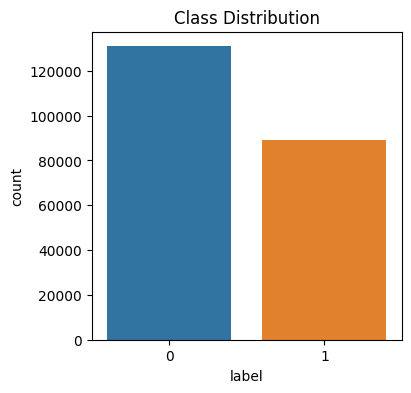

In [7]:
# Distribution
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=labels)
plt.title('Class Distribution')
plt.show()

## Build the Convolutional Neural Network models

### Model 1 : Baseline

In [8]:
# Convolution and Pooling layers
config = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
          MaxPooling2D(2,2),
          
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')]

model = Sequential(config)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from sklearn.model_selection import train_test_split

train_labels, val_labels = train_test_split(labels,
                                            test_size = 0.2,
                                            random_state = 0)

In [11]:
train_labels.head()

,id,label
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1
18438,54946370aec5fe50c6c8595e880f58051445b007,1
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1


In [12]:
# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)

# Create a new 'filename' column by adding '.tif' extension
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

In [13]:
train_labels.head()

,id,label,filename
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif
18438,54946370aec5fe50c6c8595e880f58051445b007,1,54946370aec5fe50c6c8595e880f58051445b007.tif
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0,09afaac18518e435c68fc1b635690c79b52d1a0e.tif
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1,8ab7670b07494ca3b51b570fc243467a7a45895c.tif


In [14]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Train data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

# Validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [15]:
# Model fitting
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator)
history

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730532447.520266     106 service.cc:145] XLA service 0x7de5dc007970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730532447.520305     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730532447.520309     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 8:22:09 5s/step - accuracy: 0.5000 - loss: 0.6939

I0000 00:00:1730532450.265144     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1430s 259ms/step - accuracy: 0.7687 - loss: 0.4999 - val_accuracy: 0.8472 - val_loss: 0.3611
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 461s 84ms/step - accuracy: 0.8440 - loss: 0.3617 - val_accuracy: 0.8557 - val_loss: 0.3335
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 328s 59ms/step - accuracy: 0.8622 - loss: 0.3249 - val_accuracy: 0.8741 - val_loss: 0.3018
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 341s 62ms/step - accuracy: 0.8688 - loss: 0.3119 - val_accuracy: 0.8779 - val_loss: 0.2908
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 357s 65ms/step - accuracy: 0.8758 - loss: 0.2954 - val_accuracy: 0.8814 - val_loss: 0.2873
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 388s 71ms/step - accuracy: 0.8791 - loss: 0.2889 - val_accuracy: 0.8778 - val_loss: 0.2969
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 351s 64ms/step - accuracy: 0.8826 - loss: 0.2839 - val_accuracy: 0.8733 - val_loss: 0.3023
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 342s 62ms/step - accuracy: 0.8847 - 

In [16]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

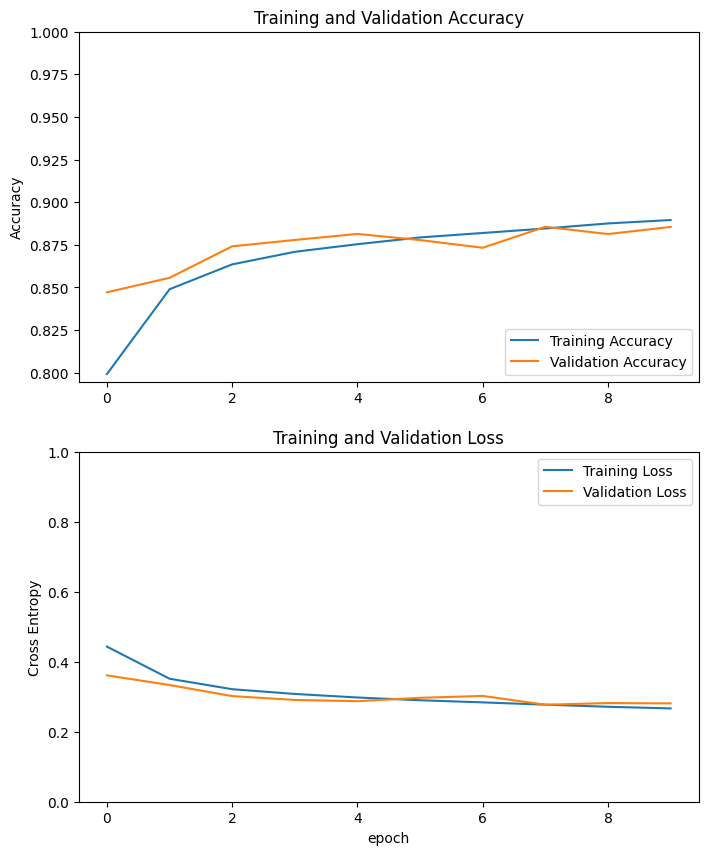

In [17]:
learning_curve(history)

### Model 2 : Deeper layers with Batch Normalization and Dropout

The baseline model has 2 convolution layers. Now, let's increase the number of convolution layers to 4.<br>
In addition, in order to enhance the stability of training and potentially speed up convergence, I apply He-initialization to the hidden layer and Xavier-initialization to the output layer.

In [19]:
# Layers
config_2 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # Fully connected layer with Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_2 = Sequential(config_2)

# Compile
learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_2.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary
model_2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
# Model fitting
history_2 = model_2.fit(train_generator,
                        epochs = 6,
                        validation_data = val_generator)
history_2

Epoch 1/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 538s 96ms/step - accuracy: 0.8058 - loss: 0.4969 - val_accuracy: 0.8684 - val_loss: 0.3117
Epoch 2/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 487s 88ms/step - accuracy: 0.8834 - loss: 0.2955 - val_accuracy: 0.8735 - val_loss: 0.3586
Epoch 3/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 477s 87ms/step - accuracy: 0.9026 - loss: 0.2542 - val_accuracy: 0.8524 - val_loss: 0.4491
Epoch 4/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 423s 77ms/step - accuracy: 0.9147 - loss: 0.2278 - val_accuracy: 0.9018 - val_loss: 0.2404
Epoch 5/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 465s 85ms/step - accuracy: 0.9216 - loss: 0.2118 - val_accuracy: 0.9261 - val_loss: 0.1986
Epoch 6/6
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 437s 79ms/step - accuracy: 0.9268 - loss: 0.1979 - val_accuracy: 0.7804 - val_loss: 1.1499


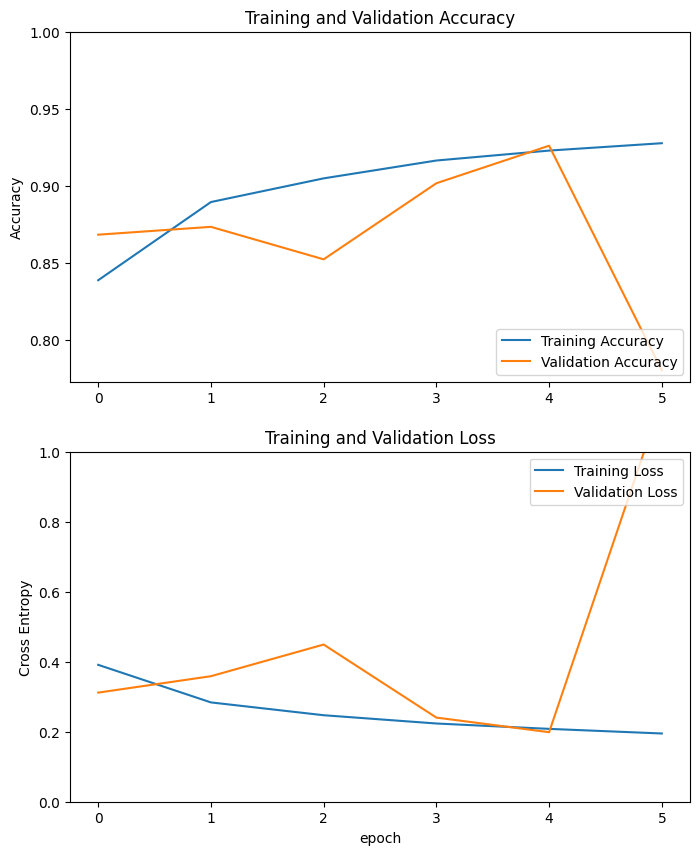

In [21]:
learning_curve(history_2)

### Model 3 : Reducing the learning rate and Increase the number of epochs

A learning rate that is too high can cause the model to overshoot the optimal solution, leading to unstable loss. Therefore, it seems worthwhile to reduce the learning rate to 0.0001.<br>
Since each update becomes smaller, the model may require more epochs to effectively learn the patterns in the data.

In [22]:
# Layers
config_3 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            # Fully connected layer with Dropout
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]

model_3 = Sequential(config_3)

# Compile
learning_rate = 0.0001 # Reduce the learning rate
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model_3.compile(optimizer = opt,
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# Summary
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,488,513 (9.49 MB)

 Trainable params: 2,487,553 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [31]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model fitting
history_3 = model_3.fit(train_generator,
                        epochs = 20,
                        validation_data = val_generator,
                        callbacks = [early_stopping])

history_3

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 534s 97ms/step - accuracy: 0.9546 - loss: 0.1223 - val_accuracy: 0.9307 - val_loss: 0.1920
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 569s 103ms/step - accuracy: 0.9559 - loss: 0.1195 - val_accuracy: 0.9391 - val_loss: 0.1706
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 542s 98ms/step - accuracy: 0.9578 - loss: 0.1151 - val_accuracy: 0.9398 - val_loss: 0.1626
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 543s 99ms/step - accuracy: 0.9570 - loss: 0.1132 - val_accuracy: 0.9443 - val_loss: 0.1568
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 521s 95ms/step - accuracy: 0.9604 - loss: 0.1061 - val_accuracy: 0.9280 - val_loss: 0.2122
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 501s 91ms/step - accuracy: 0.9609 - loss: 0.1055 - val_accuracy: 0.9438 - val_loss: 0.1703
Epoch 7/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 500s 91ms/step - accuracy: 0.9627 - loss: 0.1004 - val_accuracy: 0.9441 - val_loss: 0.1623
Epoch 8/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 474s 86ms/step - accuracy:

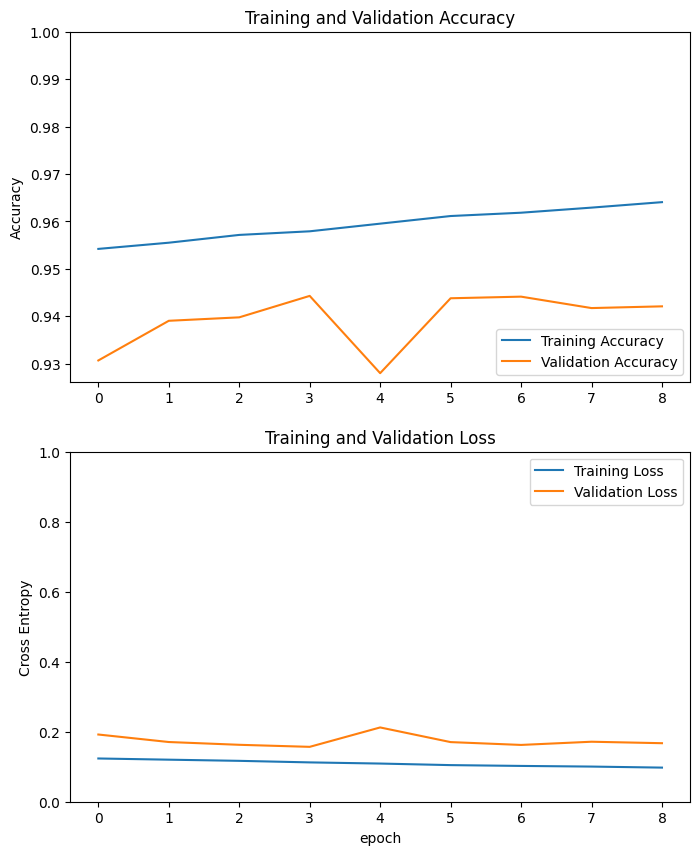

In [32]:
learning_curve(history_3)

## Conclusion and Submission

I compared three models: one consisting of two convolution layers, the second incorporating four convolution layers plus Batch Normalisation and Dropout, and the third varying the learning rate and the number of epochs of the second model.

In the validation using training data, Model 3 recorded the highest score, and the cross-entropy error also steadily decreased. By reducing the learning rate of unstable Model 2 to 0.0001 and increasing the number of iterations (epochs), I was able to obtain better weights. But it took a very long time to train Model 3.

In [33]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict on test data with model_3
test_generator.reset()
predictions = model_3.predict(test_generator, steps=test_generator.samples)

# Prepare the submission DataFrame
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission_model3_final.csv', index=False)

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step   
